# Data Availability

ADNI data can be obtained from https://adni.loni.usc.edu/
The dataset consists of peptides as columns and subjects as rows.

In [1]:
import pandas as pd
import helper_fn as hf
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import sklearn.feature_selection as fs
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import mifs
from sklearn.model_selection import cross_val_score, cross_val_predict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
import os
from scipy.stats import kruskal
from tabulate import tabulate
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import logit
import pdb
from matplotlib.lines import Line2D
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mannwhitneyu
import scipy.stats as stats
import plotly.express as px
from scipy.stats import entropy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statannot import add_stat_annotation
from sklearn.impute import KNNImputer
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Change path for saving figures
adni_figure_path = "/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/ADNI/"

# Read data
## 1. Read the EHBS Data
## 2. read the ADNI data

## Difference in EHBS and ADNI distributions

### Read Lah data

In [3]:
"""
TO DO -
Change the data_save_path to directory where the data are saved.
"""
data_save_path = "/Users/raghavtandon/Documents/PhD/multi-modal/data"
X, X_unscaled, label_df = hf.readData()
sbj_asymad = label_df[label_df["DX"] == "AsymAD"]["sbj"]
X = X[X.index.isin(sbj_asymad)]
X_unscaled = X_unscaled[X_unscaled.index.isin(sbj_asymad)]
lah_peptides = ["LGADMEDVR", "LGADMEDVCGR", "GLQEAAEER", "YDNSLK", "AQALEQAK"]
imputer = KNNImputer(n_neighbors=15)

### Function to read the ADNI data and clean its column names

In [4]:
# Refer to data availability statement
path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_followup_matched_av45.csv"
# path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_followup_matched_csf.csv"
col_name = "fdg_progression"
def read_adni(path):
    df_adni = pd.read_csv(path)
    old_cols = df_adni.columns[37:].tolist()
    new_cols = [x.split(";")[-1] for x in old_cols]
    rename_dict = dict(zip(old_cols, new_cols))
    df_adni.rename(columns=rename_dict, inplace=True)
    return df_adni

In [5]:
## Print the age distributions in ADNI data
df_adni = read_adni(path)
# print(df_adni.groupby("DX").median()["AGE"])

In [6]:
df_adni = df_adni[df_adni["DX"]=="AsymAD"]
peptides = ["ADQDTIR", "AQALEQAK", "ELQAAQAR", "EPVAGDAVPGPK", "IASNTQSR", "LGADMEDVCGR", "VVSSIEQK", "YDNSLK"]
# peptides = ["LGADMEDVR", "LGADMEDVCGR", "GLQEAAEER", "YDNSLK", "AQALEQAK"]
# peptides = ['VLTPTQVK','QSELSAK','QVVAGLNFR','LFEELVR','VIGSGCNLDSAR',
#             'IESQTQEEVR','LGADMEDVCGR','EAFSLFDK','AQALEQAK','GDLGIEIPAEK']
df_lah = X_unscaled[peptides]
df_adni = df_adni[peptides]
df_adni.columns.name = "Peptide"
df_lah = df_lah.melt()
df_lah["source"] = "Emory"
df_adni = df_adni.melt()
df_adni["source"] = "ADNI"
df_final = pd.concat([df_lah, df_adni], axis=0)

### Compare peptide distributions between ADNI and EHBS

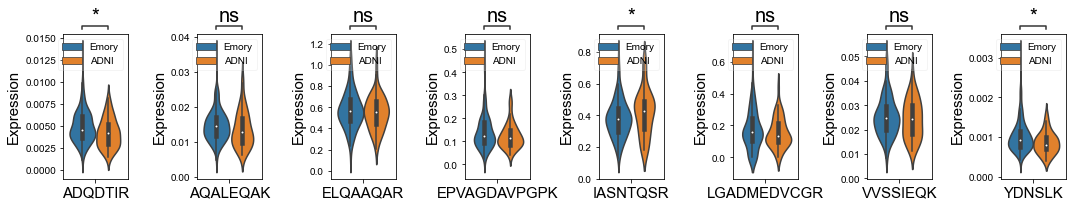

In [16]:
fig, ax = plt.subplots(1,8, figsize=(15,3), sharex=False, sharey=False)
for i in range(8):
    pep = peptides[i]
    df_final_sub = df_final[df_final["Peptide"].isin([pep])]
    sns.violinplot(data=df_final_sub, ax=ax[i], x="Peptide", y="value", hue="source")
    add_stat_annotation(ax[i], data=df_final_sub, x="Peptide", y="value", hue="source", 
                        box_pairs=[((pep, "Emory"),(pep, "ADNI"))],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=0, fontsize=20)
    ax[i].legend(loc=0, fancybox=True, framealpha=0.2)
    ax[i].set_ylabel("Expression", fontsize=15); ax[i].set_xlabel(""); ax[i].set_xticklabels([pep], fontsize=15)
fig.tight_layout()
# fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/ADNI/distr.png")

## t-SNE (CN-like vs AD_like AsymAD)

In [17]:
ss = StandardScaler()
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"]=="AsymAD"]
progression_col = col_name
df_adni = df_adni[df_adni[progression_col].isin(["YES", "NO"])]

y_adni = df_adni[progression_col].map({"YES":1, "NO":0})
# peptides = ["LGADMEDVR", "LGADMEDVCGR", "GLQEAAEER", "YDNSLK", "AQALEQAK"]
df_lah = X_unscaled[peptides]
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
df_adni_scaled = ss.fit_transform(df_adni)

In [18]:
df_lah_master = pd.read_csv("/Users/raghavtandon/Documents/PhD/multi-modal/data/final_viz_dataframe.csv", index_col='sbj')
y_lah = df_lah_master["predicted_final"]
y_lah = y_lah[y_lah.isin(["Control-like ASYMAD", "AD-like ASYMAD"])]
y_lah = y_lah.map({"AD-like ASYMAD":1, "Control-like ASYMAD":0})
df_lah["y"] = y_lah
y_lah = df_lah["y"]
del df_lah["y"]

/Users/raghavtandon/opt/miniconda3/envs/omics/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Plot the t-SNE for CN-like vs AD-like in ADNI

KL distance - 0.30161231756210327


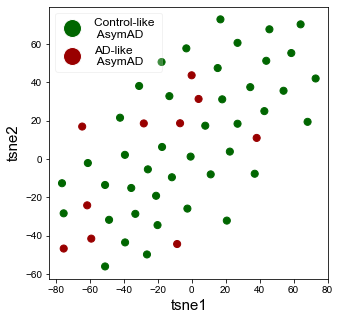

In [19]:
# df = df_adni
df = df_adni_scaled
fig, ax = plt.subplots(1,1, figsize=(5,5))
random_state=1
tsne = TSNE(n_components=2, random_state=random_state)

tsne_scores = tsne.fit_transform(df)
print("KL distance - {}".format(tsne.kl_divergence_))
ax.scatter(tsne_scores[:,0], tsne_scores[:,1], c=y_adni.replace({0: "#006600", 1: "#990000"}), s=50)
ax.set_xlabel("tsne1", fontsize=15); ax.set_ylabel("tsne2", fontsize=15)
classes10 = ["Control", "AD"]
classes11 = ["Control-like \n AsymAD", "AD-like \n AsymAD"]
lb2 = {'Control': "#006600", 'AD': "#990000"}
recs11 = hf.add_legend(classes11, [lb2[i] for i in classes10[:2]])
legend_properties = {'size':12, 'family':'Arial'}
ax.legend(recs11, [i for i in classes11], fontsize=12,
                 prop=legend_properties,
				framealpha=0.25,
				loc=0)
# fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/ADNI/jmi_peptides_adni_tsne.png")

In [20]:
df_adni = read_adni(path)
# df_adni = df_adni[df_adni["DX"].isin(["Control", "AD"])]
# y_adni = df_adni["DX"].map({"Control":0, "AD":1})
peptides = ["ADQDTIR", "AQALEQAK", "ELQAAQAR", "EPVAGDAVPGPK", "IASNTQSR", "LGADMEDVCGR", "VVSSIEQK", "YDNSLK"]
df_adni = df_adni[peptides]
imputer = KNNImputer(n_neighbors=15)
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
# df_adni["y"] = y_adni
# y_adni = df_adni["y"]
# del df_adni["y"]
# df_adni_scaled = ss.fit_transform(df_adni)

## t-SNE (Control vs AD)

In [21]:
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"].isin(["Control", "AD"])]
y_adni = df_adni["DX"].map({"Control":0, "AD":1})
peptides = ["ADQDTIR", "AQALEQAK", "ELQAAQAR", "EPVAGDAVPGPK", "IASNTQSR", "LGADMEDVCGR", "VVSSIEQK", "YDNSLK"]
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
df_adni["y"] = y_adni
y_adni = df_adni["y"]
del df_adni["y"]
df_adni_scaled = ss.fit_transform(df_adni)

KL distance - 0.3283669948577881


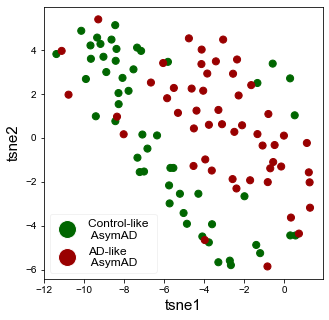

In [22]:
# df = df_adni
df = df_adni_scaled
fig, ax = plt.subplots(1,1, figsize=(5,5))
random_state=0
tsne = TSNE(n_components=2, random_state=random_state)

tsne_scores = tsne.fit_transform(df)
print("KL distance - {}".format(tsne.kl_divergence_))
ax.scatter(tsne_scores[:,0], tsne_scores[:,1], c=y_adni.replace({0: "#006600", 1: "#990000"}), s=50)
ax.set_xlabel("tsne1", fontsize=15); ax.set_ylabel("tsne2", fontsize=15)
classes10 = ["Control", "AD"]
classes11 = ["Control-like \n AsymAD", "AD-like \n AsymAD"]
lb2 = {'Control': "#006600", 'AD': "#990000"}
recs11 = hf.add_legend(classes11, [lb2[i] for i in classes10[:2]])
legend_properties = {'size':12, 'family':'Arial'}
ax.legend(recs11, [i for i in classes11], fontsize=12,
                 prop=legend_properties,
				framealpha=0.25,
				loc=0)

## Classification - CN/BM- vs AD

In [24]:
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"].isin(["Control", "AD"])]
# peptides = ["ADQDTIR", "AQALEQAK", "ELQAAQAR", "EPVAGDAVPGPK", "IASNTQSR", "LGADMEDVCGR", "VVSSIEQK", "YDNSLK"]
peptides = ["ADQDTIR", "AQALEQAK", "EPVAGDAVPGPK", "IASNTQSR", "VVSSIEQK", "YDNSLK"]
df_adni.rename(columns={"RID":"sbj"}, inplace=True)
dx_cn_ad = df_adni[["sbj", "DX"]]
df_adni.set_index("sbj", inplace=True)
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
df_adni_scaled = ss.fit_transform(df_adni[peptides])
df_adni_scaled = pd.DataFrame(df_adni_scaled, columns=df_adni.columns, index=df_adni.index)

0.9259259259259259
0.9012345679012346
0.9027777777777778
0.875
0.9305555555555556
0.6805555555555556
AuC 0.8693415637860081


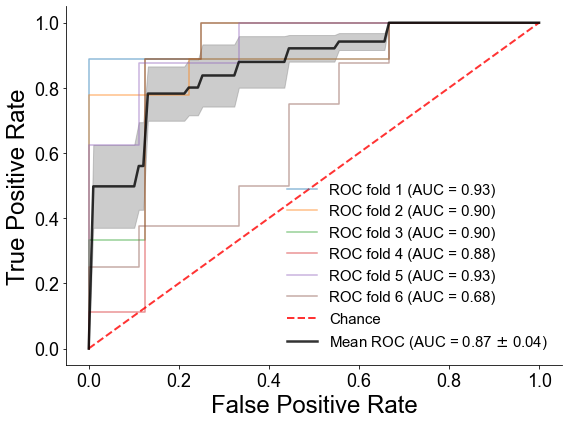

In [25]:
hf.plotROC(df_adni_scaled, dx_cn_ad, peptides, "cn_ad_no_APOE", figure_save_path=adni_figure_path)

In [26]:
path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_followup_matched_av45.csv"
df_adni = read_adni(path)
df_adni.shape

(156, 111)

## Classification (Cn-like vs AD-like)

In [62]:
path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_followup_av45.csv"
# path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_followup_matched_av45.csv"
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"].isin(["AsymAD"])]
progression_col = col_name
df_adni = df_adni[df_adni[progression_col].isin(["YES", "NO"])]
df_adni[progression_col] = df_adni[progression_col].map({"YES":1, "NO":0})
# peptides = ["AQALEQAK", "LGADMEDVCGR", "LGADMEDVR", "GLQEAAEER", "YDNSLK"]
# peptides = ["AQALEQAK", "GLQEAAEER", "YDNSLK"]
# peptides = ["ADQDTIR", "AQALEQAK", "ELQAAQAR", "EPVAGDAVPGPK", "IASNTQSR", "LGADMEDVCGR", "VVSSIEQK", "YDNSLK"]
peptides = ["ADQDTIR", "AQALEQAK", "EPVAGDAVPGPK", "IASNTQSR", "VVSSIEQK", "YDNSLK"]
df_adni.rename(columns={"RID":"sbj"}, inplace=True)
dx_cn_ad = df_adni[["sbj", progression_col]]
df_adni.set_index("sbj", inplace=True)
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
dx_cn_ad.rename(columns={progression_col:"DX"}, inplace=True)
df_adni = df_adni[peptides]
df_adni_scaled = ss.fit_transform(df_adni)
df_adni_scaled = pd.DataFrame(df_adni_scaled, columns=df_adni.columns, index=df_adni.index)

In [63]:
print("Count of stable and progressive AsymAD", Counter(dx_cn_ad["DX"]))

Count of stable and progressive AsymAD Counter({0: 42, 1: 10})


1.0
0.7857142857142857
0.9285714285714286
0.8571428571428572
0.8571428571428572
1.0
AuC 0.9047619047619048


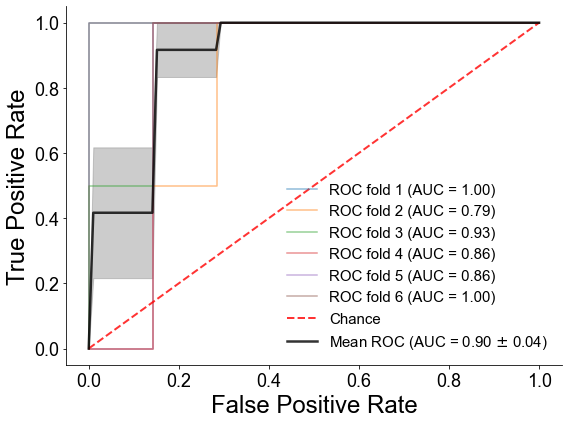

In [64]:
hf.plotROC(df_adni_scaled, dx_cn_ad, peptides, "cn_like_ad_like_no_APOE", figure_save_path=adni_figure_path)

In [30]:
def norm_cnf(cnf):
    return cnf/cnf.sum(axis=1)[:,None]

def get_cnf_mat(clf, X, y, cv=6):
    kcv = StratifiedKFold(n_splits=cv, random_state=0, shuffle=True)
    y_predict = model_selection.cross_val_predict(clf, X, y, cv=kcv)
    cnf_matrix = sm.confusion_matrix(y, y_predict)
    return cnf_matrix

In [31]:
clf = LogisticRegression( C=1.0, random_state=0, dual=False, max_iter=3000, class_weight="balanced")
kcv = StratifiedKFold(n_splits=6, random_state=0, shuffle=True)
y_predict = cross_val_predict(clf, df_adni_scaled, dx_cn_ad["DX"], cv=kcv)
pep_cnf = sm.confusion_matrix(dx_cn_ad["DX"], y_predict)
print(pep_cnf)

[[35  7]
 [ 2  8]]


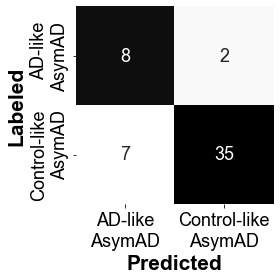

In [32]:
fig, ax = plt.subplots(figsize=(4,4))
fmt = 'png'
labels = ["AD-like\nAsymAD","Control-like\nAsymAD"]
# labels = ["AD", "CN"]
pep_cnf = pep_cnf[::-1,::-1]
sns.heatmap(norm_cnf(pep_cnf), annot=pep_cnf, cmap="Greys", fmt="d", cbar=False, 
            xticklabels=labels, yticklabels=labels, ax=ax,
            annot_kws={"fontsize":18})
ax.set_xticklabels(labels, fontsize=18, fontname="Arial")
ax.set_yticklabels(labels, fontsize=18, fontname="Arial")
# ax.xaxis.tick_top()
ax.set_xlabel("Predicted", fontsize=21, fontweight="heavy", fontname="Arial")
ax.set_ylabel("Labeled", fontsize=21, fontweight="heavy", fontname="Arial")
fig.tight_layout()
fig.savefig(os.path.join(adni_figure_path, "intra_asym_heatmap.{}".format(fmt)), 
            format=fmt, dpi=600, transparent=True)

## Important note - The matched data was used from the overall AV45 file. It has the same list of AsymAD subjects (progressives and controls)

### Leave one out CV

In [33]:
x_new = pd.merge(df_adni_scaled, dx_cn_ad, left_index=True, right_on="sbj", how="inner")
df_adni = x_new[peptides]
dx_cn_ad = x_new[["sbj", "DX"]]

In [34]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
x_adni = df_adni.values
y_adni = dx_cn_ad["DX"].values
clf = LogisticRegression( C=1.0, random_state=0, dual=False, max_iter=3000, class_weight="balanced")
y_true=[];y_pred = [];
for i, (train_index, test_index) in enumerate(loo.split(df_adni)):
    x_train = x_adni[train_index,:]
    x_test = x_adni[test_index,:]
    y_train = y_adni[train_index]
    y_test = y_adni[test_index]
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_test)
    y_true.append(y_test)
    y_pred.append(y_predict)
    

In [35]:
sm.f1_score(np.array(y_true), np.array(y_pred))

0.6666666666666666

In [36]:
sm.top_k_accuracy_score(np.array(y_true), np.array(y_pred))

/Users/raghavtandon/opt/miniconda3/envs/omics/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:1698: UndefinedMetricWarning:

'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.



1.0

In [38]:
from sklearn.utils import shuffle
X = x_adni; y = y_adni;

In [39]:
for _ in range(100):
    X, y = shuffle(X, y)
x_train = X[:40,:]; y_train = y[:40]; x_test = X[40:,:]; y_test = y[40:];
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
# sm.confusion_matrix(y_test, y_pred)
print(sm.f1_score(y_test, y_pred))

0.0


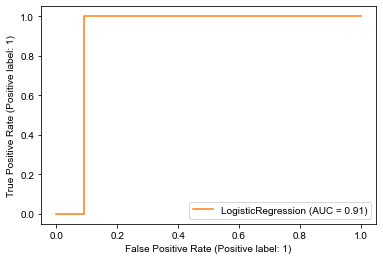

In [40]:
fig, ax = plt.subplots(1,1)
mean_fpr = np.linspace(0,1,100)
interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
ax.plot(mean_fpr, interp_tpr)
viz = sm.plot_roc_curve(clf, x_test, y_test, ax=ax)

In [41]:
viz.roc_auc

0.9090909090909091

In [42]:
viz.fpr; viz.tpr; interp_tpr

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [43]:
interp_tpr[0] = 0

In [44]:
interp_tpr

array([ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [45]:
tprs = [interp_tpr, interp_tpr]
# tprs.append(interp_tpr)

In [46]:
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sm.auc(mean_fpr, mean_tpr)

In [47]:
mean_auc

nan

## CN vs AsymAD

In [48]:
path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_cn_asymad_matched.csv"
def read_adni(path):
    df_adni = pd.read_csv(path)
    old_cols = df_adni.columns[37:].tolist()
    new_cols = [x.split(";")[-1] for x in old_cols]
    rename_dict = dict(zip(old_cols, new_cols))
    df_adni.rename(columns=rename_dict, inplace=True)
    return df_adni

In [49]:
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"]=="AsymAD"]
# peptides = ["LGADMEDVR", "LGADMEDVCGR", "GLQEAAEER", "YDNSLK", "AQALEQAK"]
peptides = ["ADQDTIR", "AQALEQAK", "ELQAAQAR", "EPVAGDAVPGPK", "IASNTQSR", "LGADMEDVCGR", "VVSSIEQK", "YDNSLK"]
# peptides = ['VLTPTQVK','QSELSAK','QVVAGLNFR','LFEELVR','VIGSGCNLDSAR',
#             'IESQTQEEVR','LGADMEDVCGR','EAFSLFDK','AQALEQAK','GDLGIEIPAEK']
df_lah = X_unscaled[peptides]
df_adni = df_adni[peptides]
df_adni.columns.name = "Peptide"
df_lah = df_lah.melt()
df_lah["source"] = "Emory"
df_adni = df_adni.melt()
df_adni["source"] = "ADNI"
df_final = pd.concat([df_lah, df_adni], axis=0)

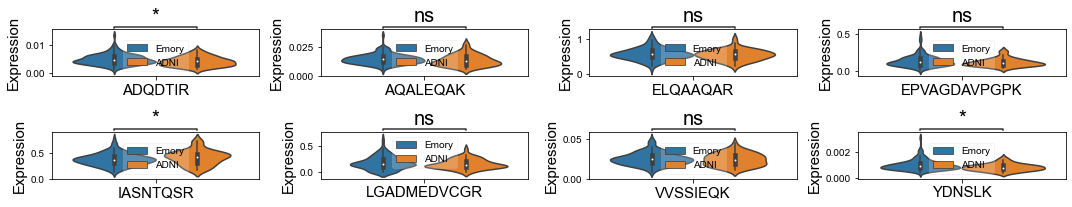

In [53]:
fig, ax = plt.subplots(2,4, figsize=(15,3), sharex=False, sharey=False)
for i in range(8):
    pep = peptides[i]
    df_final_sub = df_final[df_final["Peptide"].isin([pep])]
    sns.violinplot(data=df_final_sub, ax=ax[i//4,i%4], x="Peptide", y="value", hue="source")
    add_stat_annotation(ax[i//4,i%4], data=df_final_sub, x="Peptide", y="value", hue="source", 
                        box_pairs=[((pep, "Emory"),(pep, "ADNI"))],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=0, fontsize=20)
    ax[i//4,i%4].legend(loc=0, fancybox=True, framealpha=0.2)
    ax[i//4,i%4].set_ylabel("Expression", fontsize=15); ax[i//4,i%4].set_xlabel(""); ax[i//4,i%4].set_xticklabels([pep], fontsize=15)
fig.tight_layout()
# fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/ADNI/distr_cn_asymad.png")

## t-SNE (Control vs AsymAD)

In [54]:
df_adni = read_adni(path)
ss = StandardScaler()
df_adni = df_adni[df_adni["DX"].isin(["Control", "AsymAD"])]
y_adni = df_adni["DX"].map({"Control":0, "AsymAD":1})
peptides = ["ADQDTIR", "AQALEQAK", "ELQAAQAR", "EPVAGDAVPGPK", "IASNTQSR", "LGADMEDVCGR", "VVSSIEQK", "YDNSLK"]
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
df_adni["y"] = y_adni
y_adni = df_adni["y"]
del df_adni["y"]
df_adni_scaled = ss.fit_transform(df_adni)

KL distance - 0.30242449045181274


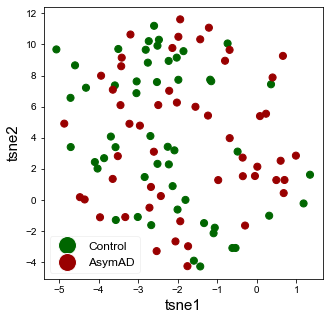

In [55]:
# df = df_adni
df = df_adni_scaled
fig, ax = plt.subplots(1,1, figsize=(5,5))
random_state=0
tsne = TSNE(n_components=2, random_state=random_state)

tsne_scores = tsne.fit_transform(df)
print("KL distance - {}".format(tsne.kl_divergence_))
ax.scatter(tsne_scores[:,0], tsne_scores[:,1], c=y_adni.replace({0: "#006600", 1: "#990000"}), s=50)
ax.set_xlabel("tsne1", fontsize=15); ax.set_ylabel("tsne2", fontsize=15)
classes10 = ["Control", "AD"]
classes11 = ["Control", "AsymAD"]
lb2 = {'Control': "#006600", 'AD': "#990000"}
recs11 = hf.add_legend(classes11, [lb2[i] for i in classes10[:2]])
legend_properties = {'size':12, 'family':'Arial'}
ax.legend(recs11, [i for i in classes11], fontsize=12,
                 prop=legend_properties,
				framealpha=0.25,
				loc=0)
# fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/ADNI/cn_asymad_tsne.png")

## Classification CN/BM- vs AsymAD

In [56]:
path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_followup_matched_av45.csv"
# path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_followup_av45.csv"

In [57]:
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"].isin(["Control", "AsymAD"])]
df_adni.rename(columns={"RID":"sbj"}, inplace=True)
dx_cn_ad = df_adni[["sbj", "DX"]]
df_adni.set_index("sbj", inplace=True)
peptides = ["ADQDTIR", "AQALEQAK", "EPVAGDAVPGPK", "IASNTQSR", "VVSSIEQK", "YDNSLK", "ELQAAQAR", "LGADMEDVCGR"]
# peptides = ["ADQDTIR", "AQALEQAK", "EPVAGDAVPGPK", "IASNTQSR", "VVSSIEQK", "YDNSLK"]
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
df_adni_scaled = ss.fit_transform(df_adni[peptides])
df_adni_scaled = pd.DataFrame(df_adni_scaled, columns=df_adni.columns, index=df_adni.index)

0.7654320987654322
0.7777777777777778
0.75
0.5555555555555556
0.8611111111111112
0.48611111111111116
AuC 0.6993312757201647


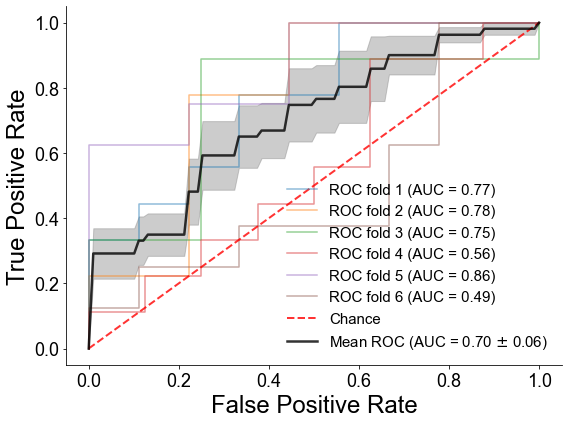

In [58]:
hf.plotROC(df_adni_scaled, dx_cn_ad, peptides, "cn_asymad", figure_save_path=adni_figure_path)

In [ ]:
peptides